In [1]:
import boto3
import datetime
import json
import pandas as pd
import os
from pathlib import Path
import json

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt  

In [2]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from itertools import cycle
from sklearn.metrics import accuracy_score
import numpy as np
from numpy import interp
from pycm import *
from sklearn.metrics import log_loss
from sklearn.metrics import balanced_accuracy_score

In [3]:
def time_converter(o):
    if isinstance(o, datetime.datetime):
        return o.__str__()

rootpath = os.path.join(r'replace your path here\mturk-task-helper')
answers_path = os.path.join(rootpath,"batch100_HITs","answers", "1selwyn_answers_classification_task_layout2_3_batch100.csv")
results_path = os.path.join(rootpath,"batch100_HITs","all")
output_results = os.path.join(rootpath,"batch100_HITs","all","results")

if not os.path.exists(output_results):
    os.mkdir(output_results)

In [4]:

region_name = 'us-east-1'

endpoint_url = 'https://mturk-requester-sandbox.us-east-1.amazonaws.com'
prod_url = "https://mturk-requester.us-east-1.amazonaws.com"

client = boto3.client(
    'mturk',
    endpoint_url=prod_url,
    region_name=region_name,
)
# This will return $10,000.00 in the MTurk Developer Sandbox
print(client.get_account_balance()['AvailableBalance'])

178.50


In [5]:
files = os.listdir(os.path.join(results_path))
files

['all_batch_results.csv',
 'Batch_4408617_batch_results.csv',
 'Batch_4408618_batch_results.csv',
 'Batch_4421963_batch_results.csv',
 'results']

In [6]:
def save_file(final_results:[dict],filename_with_ext):
    result = pd.DataFrame.from_dict(final_results)
    result.to_csv(os.path.join(os.getcwd(),filename_with_ext), index=False)

In [7]:
filename = 'all_batch_results.csv'
df = pd.read_csv(os.path.join(results_path, filename))

In [8]:
df.columns

Index(['HITId', 'HITTypeId', 'Title', 'Description', 'Keywords', 'Reward',
       'CreationTime', 'MaxAssignments', 'RequesterAnnotation',
       'AssignmentDurationInSeconds', 'AutoApprovalDelayInSeconds',
       'Expiration', 'NumberOfSimilarHITs', 'LifetimeInSeconds',
       'AssignmentId', 'WorkerId', 'AssignmentStatus', 'AcceptTime',
       'SubmitTime', 'AutoApprovalTime', 'ApprovalTime', 'RejectionTime',
       'RequesterFeedback', 'WorkTimeInSeconds', 'LifetimeApprovalRate',
       'Last30DaysApprovalRate', 'Last7DaysApprovalRate', 'Input.image1_url',
       'Input.image2_url', 'Input.image3_url', 'Input.image4_url',
       'Input.image5_url', 'Input.image6_url', 'Input.image7_url',
       'Input.image8_url', 'Input.image9_url', 'Input.image10_url',
       'Input.image11_url', 'Input.image12_url', 'Input.image13_url',
       'Input.image14_url', 'Input.image15_url', 'Input.image16_url',
       'Input.image17_url', 'Input.image18_url', 'Input.image19_url',
       'Input.image20_

In [9]:
submitted_answers = df[['HITId','Answer.taskAnswers', 'WorkerId', 'WorkTimeInSeconds', 'LifetimeApprovalRate','Approve', 'Reject']]

In [10]:
submitted_answers['WorkTimeInSeconds'].max()

1016

In [11]:
submitted_answers.columns

Index(['HITId', 'Answer.taskAnswers', 'WorkerId', 'WorkTimeInSeconds',
       'LifetimeApprovalRate', 'Approve', 'Reject'],
      dtype='object')

In [12]:
workers = list(submitted_answers.groupby(['WorkerId']).groups.keys())
print("Number of unique workers:",len(workers))

Number of unique workers: 11


In [13]:
workerid = workers[0]

In [14]:
submitted_answers.loc[submitted_answers['WorkerId'] == workerid]['WorkTimeInSeconds']

1    463
Name: WorkTimeInSeconds, dtype: int64

In [15]:
answers = pd.read_csv(answers_path)

In [16]:
answers.columns

Index(['image_name', 'W', 'H', 'x', 'y', 'class', 'image_url'], dtype='object')

### Uncomment following to see answers format and values

In [17]:
#answers.head() 

In [18]:
hitids = list(submitted_answers.groupby(['HITId']).groups.keys())

In [19]:
print("Number of unique HITs: ",len(hitids))

Number of unique HITs:  3


In [20]:
hit_wise_scores = dict()
for id in hitids:
    hit_wise_scores[id] = dict() 

In [21]:
#print(json.loads(submitted_answers))
all_count = len(submitted_answers)
count = 0
answer_count = 0
scores_dict = []
worker_total_scores = 0
image_wise_scores = []
worker_wise_scores = []
hit_wise_scores = []
total_hit_time = 0
total_hit_score = 0
scores = 0
task_count = 0
total_worker_time = 0
feedback = ""

### For each worker, get submitted answers, compare against answers and score
25 vehicles images, scores =  total correct answers/25

In [22]:
for worker in workers:
    worker_total_scores = 0
    total_worker_time = 0
    worker_answers = submitted_answers.loc[submitted_answers['WorkerId'] == worker]

    #print(len(worker_answers.index))
    for index in worker_answers.index:
        feedback = ""
        ans = worker_answers['Answer.taskAnswers'][index]
        #print(ans.replace("[","").replace("]",""))
        ajson = json.loads(ans.replace("[","").replace("]",""))
        for k,v in ajson.items():
            if k != "feedback":
                #print(answers['image_url'] , k)
                #print(len(k.split("/")))
                #_,_,_,folder,filename = k.split("/")
                #print(folder+"/"+filename)
                
                exists = k in answers['image_url'].tolist()
                values = answers.loc[answers['image_url'] == k]
                t = type(v)
                #print( count,k)
                if t == dict:
                    label_value = v['label'] if v['label'] else "None"
                    answered = label_value.replace(": ","").strip()
                else:
                    answered = v.replace(": ","").strip()

                if answered == values.iloc[0]['class']:
                    image_wise_scores.append({"image_url":k, "submitted":answered, "answer": values.iloc[0]['class'], "score":1,"WorkerId":worker,"HITId": worker_answers['HITId'][index],})
                    scores += 1
                    count  += 1
                elif answered != values.iloc[0]['class'] and (answered == 'None' or answered == 'Not relevant vehicles'):
                    image_wise_scores.append({"image_url":k,"submitted":answered, "answer": values.iloc[0]['class'], "score":0, "WorkerId":worker,"HITId": worker_answers['HITId'][index],})
                    count += 1
                else:
                    image_wise_scores.append({"image_url":k,"submitted":answered, "answer": values.iloc[0]['class'],"score":0,"WorkerId":worker,"HITId": worker_answers['HITId'][index],})
                    count += 1
            else:
                feedback = v
                print(v)
        percent_score = scores*100/25
        approve = ""
        reject = ""
        if percent_score > 70:
            approve = "x"
        else:
            reject = "Number of incorrect class labels are more. Sorry. Maybe you can spend a bit more time and utilize duration of task and utlizie looking at examples."
        scores_dict.append({"WorkerId":worker, "HITId":worker_answers['HITId'][index],"total_worker_score":scores,"task_percentage_score":percent_score,
                            "approve":approve, "reject":reject,"WorkTimeInSeconds":worker_answers['WorkTimeInSeconds'][index], "LifetimeApprovalRate":worker_answers['LifetimeApprovalRate'][index]})
        
        image_wise_scores.append({"WorkerId":worker,"HITId": worker_answers['HITId'][index],"total_score":scores,"approve":approve, "reject":reject, "WorkTimeInSeconds":worker_answers['WorkTimeInSeconds'][index], "LifetimeApprovalRate":worker_answers['LifetimeApprovalRate'][index]})
        total_worker_time += worker_answers['WorkTimeInSeconds'][index]
        
        if count == 25:
            worker_total_scores += scores
            answer_count += 1
            count = 0
            scores = 0
    print(worker_total_scores,25*len(worker_answers.index),len(worker_answers.index) , worker_total_scores*100/(25*len(worker_answers.index)))
    worker_percent_score = worker_total_scores*100/(25*len(worker_answers.index))
    worker_wise_scores.append({"WorkerId":worker,"total_worker_score":worker_total_scores,"worker_percent_score":worker_percent_score,
                        "TotalWorkTimeInSeconds":total_worker_time, "total_tasks": len(worker_answers.index),"LifetimeApprovalRate":worker_answers['LifetimeApprovalRate'][index], "feedback":feedback})


18 25 1 72.0
31 50 2 62.0
22 25 1 88.0
17 25 1 68.0
20 25 1 80.0
43 50 2 86.0
33 50 2 66.0
Some images were very difficult.
17 25 1 68.0
16 25 1 64.0
Some of the images are hard to make out. It would be better to have a misc or cannot tell from image section. 
40 50 2 80.0
18 25 1 72.0


In [23]:
all_count,answer_count

(15, 15)

In [24]:
len(scores_dict), len(image_wise_scores)

(15, 390)

In [25]:
raw_results = pd.DataFrame.from_dict(scores_dict)
raw_results.to_csv(os.path.join(output_results,"selwyn_raw_classification_scores_all.csv"), index=False)

In [26]:
image_wise_results = pd.DataFrame.from_dict(image_wise_scores)
image_wise_results.to_csv(os.path.join(output_results,"selwyn_image_wise_worker_classification_scores_all.csv"), index=False)

In [27]:
result = pd.DataFrame.from_dict(worker_wise_scores)
result.to_csv(os.path.join(output_results,"selwyn_worker_wise_classification_scores_all.csv"), index=False)

In [28]:
print(len(worker_wise_scores))

11


In [29]:
best_workers = []

In [30]:
best_worker_wise_scores = []

In [31]:
for worker_score in worker_wise_scores:
    print(worker_score['worker_percent_score'],float(worker_score['worker_percent_score']) > 70.0)
    if float(worker_score['worker_percent_score']) > 70.0:
        best_workers.append(worker_score['WorkerId'])
        best_worker_wise_scores.append(worker_score)

72.0 True
62.0 False
88.0 True
68.0 False
80.0 True
86.0 True
66.0 False
68.0 False
64.0 False
80.0 True
72.0 True


In [32]:
print( "Number of best worker", len(best_workers))
print("Number of workers ", len(worker_wise_scores))

Number of best worker 6
Number of workers  11


In [33]:
len(best_worker_wise_scores)

6

In [34]:
result = pd.DataFrame.from_dict(best_worker_wise_scores)
result.to_csv(os.path.join(output_results,"new","selwyn_best_worker_wise_classification_scores_all.csv"), index=False)

In [35]:
labels = answers['class'].unique().tolist()
labels

['Trucks',
 'Small trailers',
 'Specialized vehicles',
 'Large trailers',
 'Small vehicles',
 'Vans and RVs']

In [36]:
print("Buses are not there in this batch of images.")

Buses are not there in this batch of images.


In [37]:
labels = ['Trucks', 'Small trailers', 'Specialized vehicles',
       'Large trailers', 'Small vehicles', 'Vans and RVs','Buses']

In [38]:
def plot_roc(answers_labels, worker_hit_labels, labels, roc_filename_path):
    
    classification_report = []
    acc = {}
    y_ans = label_binarize(answers_labels, classes=labels)
    y_sub = label_binarize(worker_hit_labels, classes=labels)
    
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(len(labels)):
        fpr[i], tpr[i], _ = roc_curve(y_ans[:, i], y_sub[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        acc[labels[i]] = {}
        acc[labels[i]] = accuracy_score(y_ans[:, i], y_sub[:, i])
        
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_ans.ravel(), y_sub.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(labels))]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(len(labels)):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= len(labels)

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
#     plt.figure()
#     plt.plot(fpr["micro"], tpr["micro"],
#              label='micro-average ROC curve (area = {0:0.2f})'
#                    ''.format(roc_auc["micro"]),
#              color='deeppink', linestyle=':', linewidth=4)

    # plt.plot(fpr["macro"], tpr["macro"],
    #          label='macro-average ROC curve (area = {0:0.2f})'
    #                ''.format(roc_auc["macro"]),
    #          color='navy', linestyle=':', linewidth=4)
    worker, hitid,_ = os.path.basename(roc_filename_path).split(".")[0].split("_")
    
    colors = cycle(['red', 'green','blue','violet', 'deepskyblue', 'darkorange', 'cyan','lime' ])
    for i, color in zip(range(len(labels)), colors):
#         plt.plot(fpr[i], tpr[i], color=color, lw=lw,
#                  label='ROC curve of class {0} (area = {1:0.2f})'
#                  ''.format(i, roc_auc[i]))
        classification_report.append({"label":labels[i],"accuracy":acc[labels[i]],"tpr": tpr[i].tolist(), "fpr": fpr[i].tolist(),"worker": worker, "hitid":hitid})
        
#     plt.plot([0, 1], [0, 1], 'k--', lw=lw)
#     plt.xlim([-0.01, 1.01])
#     plt.ylim([0.0, 1.05])
#     plt.xlabel('False Positive Rate')
#     plt.ylabel('True Positive Rate')
#     plt.title('Receiver operating characteristic to multi-class vehicle labels')
#     plt.legend(loc="lower right")
    #plt.savefig(roc_filename_path)
    #plt.show()
    save_file(classification_report, os.path.join(output_results,roc_filename_path.replace(".png",".csv")))

In [39]:
def calculate_cohen_kappa(worker1_labels, worker2_hit_labels, labels, worker_hit_id, hitid):
    from sklearn.metrics import cohen_kappa_score
    from sklearn.preprocessing import label_binarize
    from itertools import cycle
    class_cohen_kappa_score = {}
    class_cohen_kappa_score['worker_hit_id'] = worker_hit_id
    class_cohen_kappa_score['HITId'] = hitid
    y_ans = label_binarize(worker1_labels, classes=labels)
    y_sub = label_binarize(worker_hit_labels, classes=labels)
    scores = {}
    for i in range(len(labels)):
         class_cohen_kappa_score[labels[i]] = cohen_kappa_score(y_ans[:, i], y_sub[:, i])
    return class_cohen_kappa_score
                            

In [40]:
def cm2df(cm, labels, worker_hitid):
    df = pd.DataFrame()
    # rows
    for i, row_label in enumerate(labels):
        rowdata={}
        # columns
        for j, col_label in enumerate(labels): 
            rowdata[col_label]=cm[i,j]
        df = df.append(pd.DataFrame.from_dict({row_label:rowdata}, orient='index'))
    #df.style.set_table_attributes("style='display:inline'").set_caption(worker_hitid)
    return df[labels]

In [41]:
worker_hit_labels = []
answers_labels = []
cm =  []
urls = []
classification_report = []
total_answers_labels = []
total_worker_hit_labels = []
lw =2
all_cm = []
worker_count = 0
cohen_kappa_scores = []
answer_worker_labels = {}

c:\python38\lib\site-packages\sklearn\metrics\_ranking.py:811: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn("No positive samples in y_true, "
c:\python38\lib\site-packages\sklearn\metrics\_classification.py:620: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


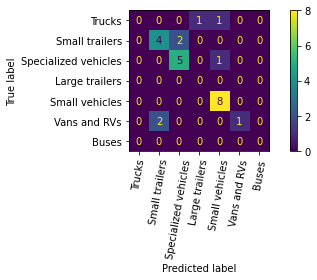

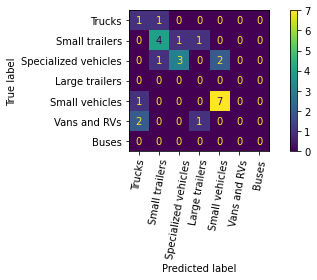

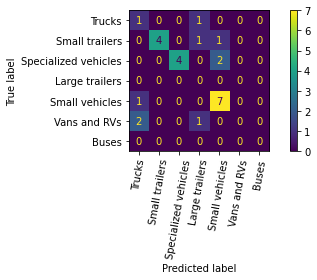

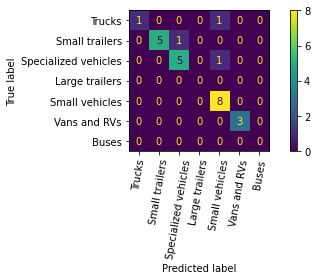

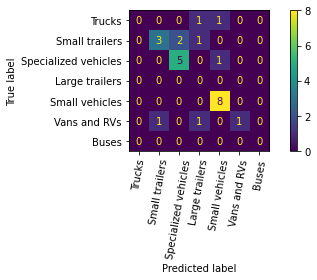

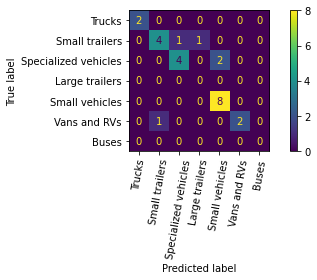

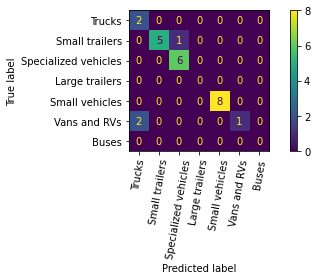

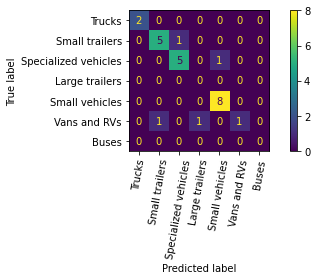

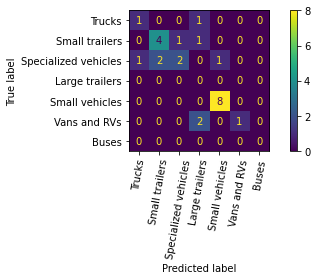

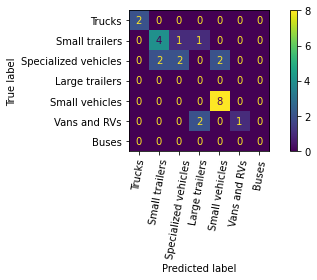

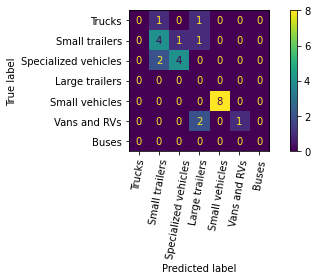

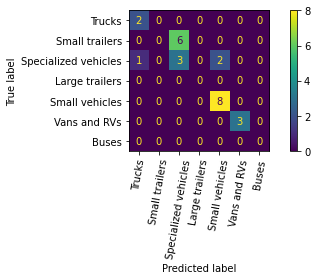

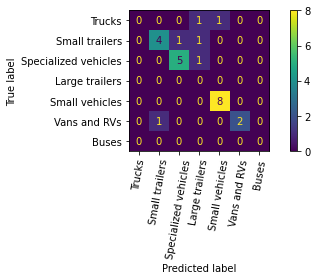

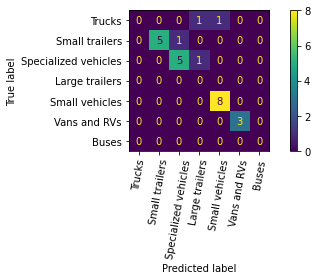

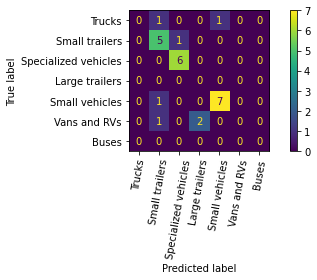

In [42]:
for worker in workers:
    
    worker_answers = submitted_answers.loc[submitted_answers['WorkerId'] == worker]

    for index in worker_answers.index:
        feedback = ""
        ans = worker_answers['Answer.taskAnswers'][index]
        ajson = json.loads(ans.replace("[","").replace("]",""))
        urls = []
        worker_hit_labels = []
        answers_labels = []
        for k,v in ajson.items():
            if k != "feedback":
                exists = k in answers['image_url'].tolist()
                values = answers.loc[answers['image_url'] == k]
                t = type(v)
                if exists:
                    urls.append(k)
                    if t == dict:
                        label_value = v['label'] if v['label'] else "None"
                        answered = label_value.replace(": ","").strip()
                    else:
                        answered = v.replace(": ","").strip()
                    
                    worker_hit_labels.append(answered);
                    answers_labels.append(values.iloc[0]['class'])
            else:
                #worker_hit_labels.append(answered);
                #answers_labels.append(values.iloc[0]['class'])
                feedback = v
        plot_roc(answers_labels, worker_hit_labels, labels, os.path.join(output_results,worker+"_"+worker_answers['HITId'][index]+"_ROC"+".png"))
        
        cohen_kappa_scores.append(calculate_cohen_kappa(answers_labels, worker_hit_labels, labels,worker+"_"+worker_answers['HITId'][index],worker_answers['HITId'][index]))
       
        answer_worker_labels[worker+"_"+worker_answers['HITId'][index]] ={"HITId":worker_answers['HITId'][index], "labels":worker_hit_labels}
        
        res = confusion_matrix(answers_labels, worker_hit_labels, labels=labels)
        #print(res, labels)
        cm_display = ConfusionMatrixDisplay(res,display_labels=labels)
        cm_display.plot(xticks_rotation=80)
        plt.tight_layout(pad=1)
        
        plt.savefig(os.path.join(output_results,worker+"_"+worker_answers['HITId'][index]+".png"), pad_inches=0.2)
        plt.tight_layout()
        all_cm.append(cm2df(res, labels,worker+"_"+worker_answers['HITId'][index]))
        cm.append({"worker_hit":worker+"_"+worker_answers['HITId'][index],"answers":answers_labels,"submitted":worker_hit_labels,"ursl":urls,"cm":res.tolist() })

In [43]:
save_file(cm,os.path.join(output_results,"confusion_matrix_results_all.csv"))

In [44]:
len(cohen_kappa_scores)

15

In [45]:
all_cohen_kappa_scores = []
for worker_hit_id1 in answer_worker_labels.keys():
    for worker_hit_id2 in answer_worker_labels.keys():
        worker1,hit1 = worker_hit_id1.split("_")
        worker2,hit2 = worker_hit_id2.split("_")
        if worker1 != worker2 and hit1 == hit2 :
            worker1_labels = answer_worker_labels[worker_hit_id1]["labels"]
            worker2_labels = answer_worker_labels[worker_hit_id2]["labels"]
            all_cohen_kappa_scores.append(calculate_cohen_kappa(worker1_labels, worker2_labels, labels,worker1 + " vs "+ worker2+ " for hit : "+hit1, hit1))

In [46]:
len(all_cohen_kappa_scores)

60

In [47]:
save_file(all_cohen_kappa_scores,os.path.join(output_results,"all_cohen_kappa_scores_layout123.csv"))

In [48]:
save_file(cohen_kappa_scores,os.path.join(output_results,"cohen_kappa_scores_layout123.csv"))

In [49]:
len(all_cm)

15

In [50]:
final = pd.concat(all_cm,axis=1, keys=workers)

In [51]:
save_file(final,os.path.join(output_results,"all_confusion_matrix_results_all.csv"))

In [52]:
save_file(classification_report, os.path.join(output_results,"classification_reports.csv"))

In [53]:
len(answers_labels)

25

In [54]:
cmr = ConfusionMatrix(actual_vector=answers_labels, predict_vector=worker_hit_labels) # Create CM From Data

In [55]:
cmr.classes

['Large trailers',
 'Small trailers',
 'Small vehicles',
 'Specialized vehicles',
 'Trucks',
 'Vans and RVs']

In [56]:
cmr.table

{'Large trailers': {'Large trailers': 0,
  'Small trailers': 0,
  'Small vehicles': 0,
  'Specialized vehicles': 0,
  'Trucks': 0,
  'Vans and RVs': 0},
 'Small trailers': {'Large trailers': 0,
  'Small trailers': 5,
  'Small vehicles': 0,
  'Specialized vehicles': 1,
  'Trucks': 0,
  'Vans and RVs': 0},
 'Small vehicles': {'Large trailers': 0,
  'Small trailers': 1,
  'Small vehicles': 7,
  'Specialized vehicles': 0,
  'Trucks': 0,
  'Vans and RVs': 0},
 'Specialized vehicles': {'Large trailers': 0,
  'Small trailers': 0,
  'Small vehicles': 0,
  'Specialized vehicles': 6,
  'Trucks': 0,
  'Vans and RVs': 0},
 'Trucks': {'Large trailers': 0,
  'Small trailers': 1,
  'Small vehicles': 1,
  'Specialized vehicles': 0,
  'Trucks': 0,
  'Vans and RVs': 0},
 'Vans and RVs': {'Large trailers': 2,
  'Small trailers': 1,
  'Small vehicles': 0,
  'Specialized vehicles': 0,
  'Trucks': 0,
  'Vans and RVs': 0}}

In [57]:
print(cmr)

Predict                    Large trailers             Small trailers             Small vehicles             Specialized vehicles       Trucks                     Vans and RVs               
Actual
Large trailers             0                          0                          0                          0                          0                          0                          

Small trailers             0                          5                          0                          1                          0                          0                          

Small vehicles             0                          1                          7                          0                          0                          0                          

Specialized vehicles       0                          0                          0                          6                          0                          0                          

Trucks                     0           

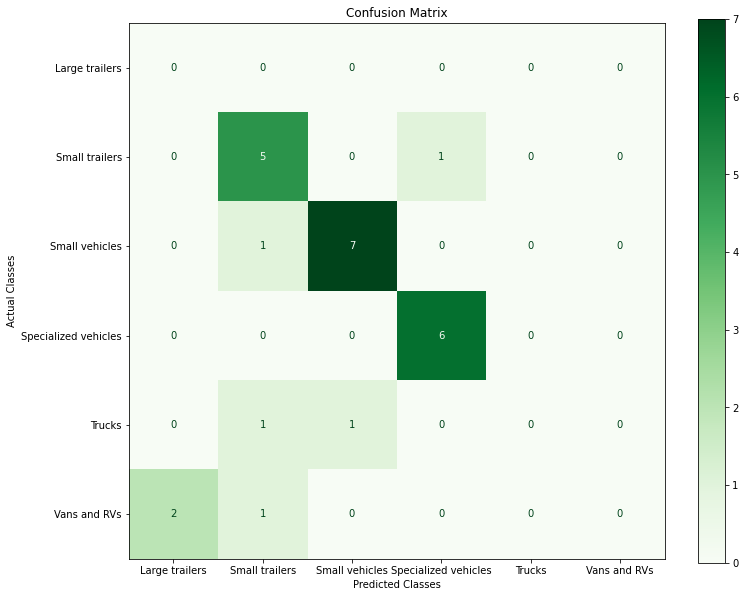

In [64]:
plt.rcParams["figure.figsize"] = (12,10)
cmr.plot(cmap=plt.cm.Greens,number_label=True,plot_lib="matplotlib")

In [174]:
plt.savefig(worker+"_"+worker_answers['HITId'][index]+".png", pad_inches=0.2)
#plt.tight_layout()
plt.show()

<Figure size 432x288 with 0 Axes>

In [65]:
len(answers_labels)

25

In [66]:
def plot_roc1(answers_labels, worker_hit_labels, labels, roc_filename_path):
    
    classification_report = []
    acc = {}
    y_ans = label_binarize(answers_labels, classes=labels)
    y_sub = label_binarize(worker_hit_labels, classes=labels)
    
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(len(labels)):
        fpr[i], tpr[i], _ = roc_curve(y_ans[:, i], y_sub[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        acc[labels[i]] = {}
        acc[labels[i]] = accuracy_score(y_ans[:, i], y_sub[:, i])
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_ans.ravel(), y_sub.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(labels))]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(len(labels)):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= len(labels)

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
#     plt.figure()
#     plt.plot(fpr["micro"], tpr["micro"],
#              label='micro-average ROC curve (area = {0:0.2f})'
#                    ''.format(roc_auc["micro"]),
#              color='deeppink', linestyle=':', linewidth=4)

    # plt.plot(fpr["macro"], tpr["macro"],
    #          label='macro-average ROC curve (area = {0:0.2f})'
    #                ''.format(roc_auc["macro"]),
    #          color='navy', linestyle=':', linewidth=4)
    colors = cycle(['red', 'green','blue','violet', 'deepskyblue', 'darkorange', 'cyan','lime' ])
    for i, color in zip(range(len(labels)), colors):
#         plt.plot(fpr[i], tpr[i], color=color, lw=lw,
#                  label='ROC curve of class {0} (area = {1:0.2f})'
#                  ''.format(i, roc_auc[i]))
        classification_report.append({"label":labels[i],"accuracy":acc[labels[i]],"tpr": tpr[i].tolist(), "fpr": fpr[i].tolist()})
#     plt.plot([0, 1], [0, 1], 'k--', lw=lw)
#     plt.xlim([-0.01, 1.01])
#     plt.ylim([0.0, 1.05])
#     plt.xlabel('False Positive Rate')
#     plt.ylabel('True Positive Rate')
#     plt.title('Receiver operating characteristic to multi-class vehicle labels')
#     plt.legend(loc="lower right")
#     plt.savefig(roc_filename_path)
#     plt.show()
    save_file(classification_report, os.path.join(output_results,roc_filename_path.replace(".png",".csv")))

In [68]:
worker_hit_labels = []
answers_labels = []
cm1 =  []
urls = []
classification_report = []
total_answers_labels = []
total_worker_hit_labels = []
normalized_cm = None

[[ 14   3   0   7   6   0   0]
 [  0  61  22   8   1   0   0]
 [  2   7  64   2  15   0   0]
 [  0   0   0   0   0   0   0]
 [  2   1   0   0 117   0   0]
 [  6   7   0  12   0  20   0]
 [  0   0   0   0   0   0   0]] ['Trucks', 'Small trailers', 'Specialized vehicles', 'Large trailers', 'Small vehicles', 'Vans and RVs', 'Buses']


<ipython-input-69-0789cf026b7c>:38: RuntimeWarning: invalid value encountered in true_divide
  normalized_cm = res1.astype('float') / res1.sum(axis=1)[:, np.newaxis]


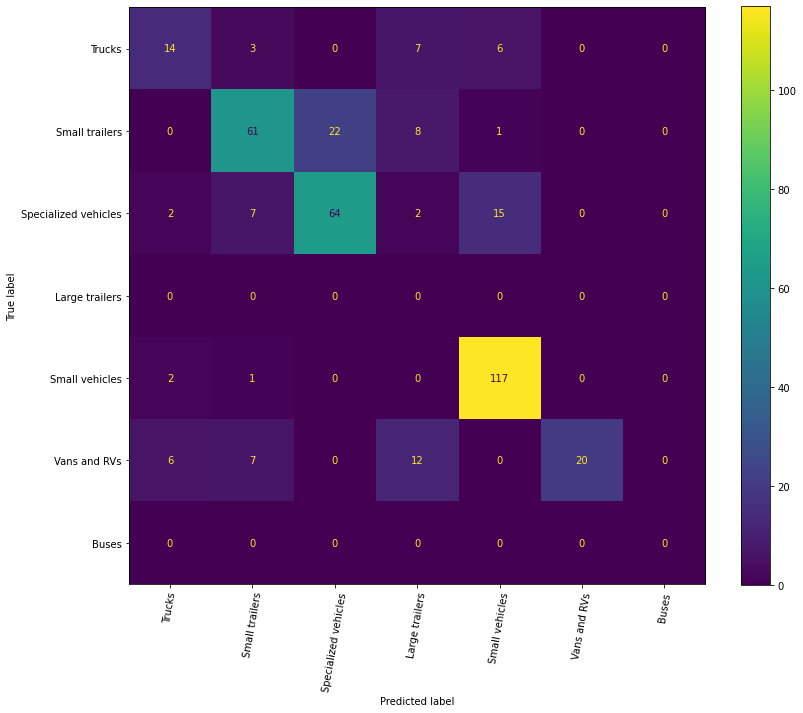

In [69]:
for worker in workers:
    
    worker_answers = submitted_answers.loc[submitted_answers['WorkerId'] == worker]

    for index in worker_answers.index:
        feedback = ""
        ans = worker_answers['Answer.taskAnswers'][index]
        ajson = json.loads(ans.replace("[","").replace("]",""))
        
        for k,v in ajson.items():
            if k != "feedback":
                exists = k in answers['image_url'].tolist()
                values = answers.loc[answers['image_url'] == k]
                t = type(v)
                if exists:
                    urls.append(k)
                    if t == dict:
                        label_value = v['label'] if v['label'] else "None"
                        answered = label_value.replace(": ","").strip()
                    else:
                        answered = v.replace(": ","").strip()
                    
                    total_worker_hit_labels.append(answered);
                    total_answers_labels.append(values.iloc[0]['class'])
            else:
                total_worker_hit_labels.append(answered);
                total_answers_labels.append(values.iloc[0]['class'])
                feedback = v
plot_roc1(total_answers_labels, total_worker_hit_labels, labels, os.path.join(output_results,"new","roc_4421963.png"))
res1 = confusion_matrix(total_answers_labels, total_worker_hit_labels, labels=labels)
print(res1, labels)
cm_display = ConfusionMatrixDisplay(res1,display_labels=labels)
cm_display.plot(xticks_rotation=80)
plt.tight_layout(pad=1)

plt.savefig(os.path.join(output_results,"cm_all"+".png"), pad_inches=0.2)
plt.tight_layout()
normalized_cm = res1.astype('float') / res1.sum(axis=1)[:, np.newaxis]
normalized_cm_sk =confusion_matrix(total_answers_labels, total_worker_hit_labels, labels=labels, normalize="true")
cm.append({"batch":"all","answers":total_answers_labels,"submitted":total_worker_hit_labels,"ursl":urls,"cm":res1 })

In [246]:
#save_file(cm, os.path.join(output_results,"overall_cm_reports_4408618.csv"))

In [70]:
res1.tolist()

[[14, 3, 0, 7, 6, 0, 0],
 [0, 61, 22, 8, 1, 0, 0],
 [2, 7, 64, 2, 15, 0, 0],
 [0, 0, 0, 0, 0, 0, 0],
 [2, 1, 0, 0, 117, 0, 0],
 [6, 7, 0, 12, 0, 20, 0],
 [0, 0, 0, 0, 0, 0, 0]]

In [71]:
normalized_cm_sk

array([[0.46666667, 0.1       , 0.        , 0.23333333, 0.2       ,
        0.        , 0.        ],
       [0.        , 0.66304348, 0.23913043, 0.08695652, 0.01086957,
        0.        , 0.        ],
       [0.02222222, 0.07777778, 0.71111111, 0.02222222, 0.16666667,
        0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        ],
       [0.01666667, 0.00833333, 0.        , 0.        , 0.975     ,
        0.        , 0.        ],
       [0.13333333, 0.15555556, 0.        , 0.26666667, 0.        ,
        0.44444444, 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        ]])

In [72]:
df = pd.DataFrame(res1.tolist(), index =labels,columns =labels)
df

,Trucks,Small trailers,Specialized vehicles,Large trailers,Small vehicles,Vans and RVs,Buses
Trucks,14,3,0,7,6,0,0
Small trailers,0,61,22,8,1,0,0
Specialized vehicles,2,7,64,2,15,0,0
Large trailers,0,0,0,0,0,0,0
Small vehicles,2,1,0,0,117,0,0
Vans and RVs,6,7,0,12,0,20,0
Buses,0,0,0,0,0,0,0


In [73]:
df.to_csv(os.path.join(output_results,"overall_best_of_worker_accuracy_cm_reports.csv"), index_label=[df.index.name, df.columns.name])

In [74]:
normalized_cm.tolist()

[[0.4666666666666667, 0.1, 0.0, 0.23333333333333334, 0.2, 0.0, 0.0],
 [0.0,
  0.6630434782608695,
  0.2391304347826087,
  0.08695652173913043,
  0.010869565217391304,
  0.0,
  0.0],
 [0.022222222222222223,
  0.07777777777777778,
  0.7111111111111111,
  0.022222222222222223,
  0.16666666666666666,
  0.0,
  0.0],
 [nan, nan, nan, nan, nan, nan, nan],
 [0.016666666666666666, 0.008333333333333333, 0.0, 0.0, 0.975, 0.0, 0.0],
 [0.13333333333333333,
  0.15555555555555556,
  0.0,
  0.26666666666666666,
  0.0,
  0.4444444444444444,
  0.0],
 [nan, nan, nan, nan, nan, nan, nan]]

In [75]:
normalized_cm_sk.tolist()

[[0.4666666666666667, 0.1, 0.0, 0.23333333333333334, 0.2, 0.0, 0.0],
 [0.0,
  0.6630434782608695,
  0.2391304347826087,
  0.08695652173913043,
  0.010869565217391304,
  0.0,
  0.0],
 [0.022222222222222223,
  0.07777777777777778,
  0.7111111111111111,
  0.022222222222222223,
  0.16666666666666666,
  0.0,
  0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.016666666666666666, 0.008333333333333333, 0.0, 0.0, 0.975, 0.0, 0.0],
 [0.13333333333333333,
  0.15555555555555556,
  0.0,
  0.26666666666666666,
  0.0,
  0.4444444444444444,
  0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]

In [76]:
df1 = pd.DataFrame(normalized_cm.tolist(), index =labels,columns =labels)
df1

,Trucks,Small trailers,Specialized vehicles,Large trailers,Small vehicles,Vans and RVs,Buses
Trucks,0.466667,0.100000,0.000000,0.233333,0.200000,0.000000,0.0
Small trailers,0.000000,0.663043,0.239130,0.086957,0.010870,0.000000,0.0
Specialized vehicles,0.022222,0.077778,0.711111,0.022222,0.166667,0.000000,0.0
Large trailers,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Small vehicles,0.016667,0.008333,0.000000,0.000000,0.975000,0.000000,0.0
Vans and RVs,0.133333,0.155556,0.000000,0.266667,0.000000,0.444444,0.0
Buses,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [77]:
df1.to_csv(os.path.join(output_results,"overall_best_of_worker_accuracy_normalized_cm_reports.csv"), index_label=[df.index.name, df.columns.name])

In [78]:
cmr = ConfusionMatrix(actual_vector=total_answers_labels, predict_vector=total_worker_hit_labels) # Create CM From Data

In [79]:
print(cmr)

Predict                    Large trailers             Small trailers             Small vehicles             Specialized vehicles       Trucks                     Vans and RVs               
Actual
Large trailers             0                          0                          0                          0                          0                          0                          

Small trailers             8                          61                         1                          22                         0                          0                          

Small vehicles             0                          1                          117                        0                          2                          0                          

Specialized vehicles       2                          7                          15                         64                         2                          0                          

Trucks                     7           

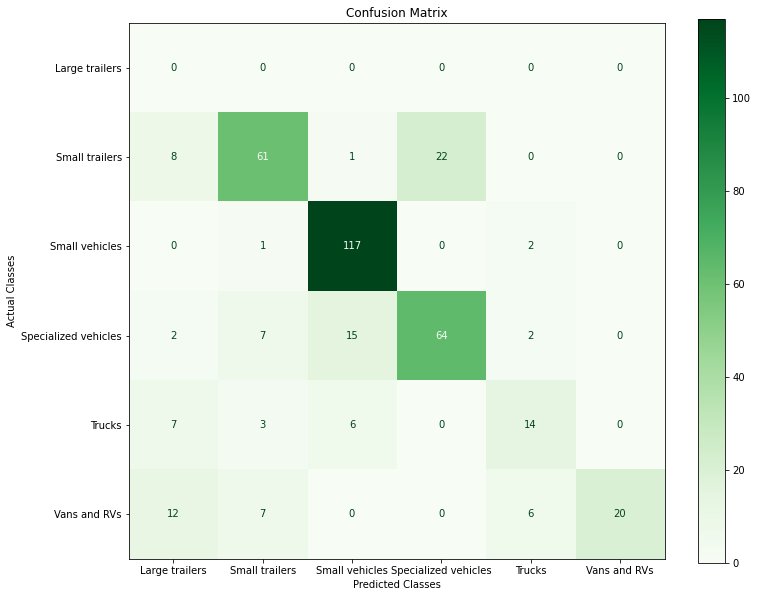

In [80]:
plt.rcParams["figure.figsize"] = (12,10)
cmr.plot(cmap=plt.cm.Greens,number_label=True,plot_lib="matplotlib")

In [82]:
cmr.to_array(normalized=True).tolist()

[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.08696, 0.66304, 0.01087, 0.23913, 0.0, 0.0],
 [0.0, 0.00833, 0.975, 0.0, 0.01667, 0.0],
 [0.02222, 0.07778, 0.16667, 0.71111, 0.02222, 0.0],
 [0.23333, 0.1, 0.2, 0.0, 0.46667, 0.0],
 [0.26667, 0.15556, 0.0, 0.0, 0.13333, 0.44444]]

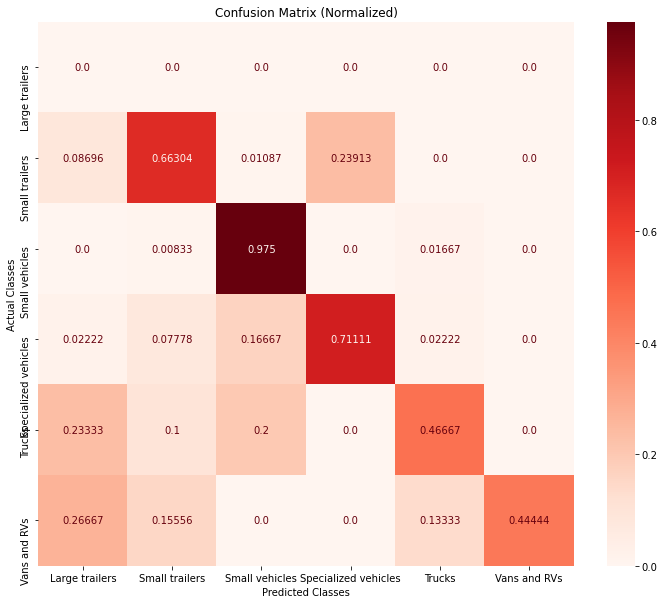

In [83]:
cmr.plot(cmap=plt.cm.Reds,normalized=True,number_label=True,plot_lib="seaborn")